Projec 3
Wei Jun Ong 905759266
Weikeng Yang 405346443
Chenggong 205837871

In [ ]:
!pip install surprise
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505171 sha256=e42f628dd164d6c8f7615bacef37ba9ee77bf1f99a117980a88f7350fc0c5849
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [43]:
from google.colab import drive
drive.mount('/content/drive')

PATH = '/content/drive/MyDrive/Colab Notebooks/ECE219_Project3/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import NMF
from google.colab import drive
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import KNNBasic



## QUESTION 1:

Explore the Dataset: In this question, we explore the structure of the data.

In [ ]:
# reading csv files
#   movies
mv = pd.read_csv(PATH + 'Dataset/movies.csv')  #<class 'pandas.core.frame.DataFrame'>
mv.dropna(inplace=True)
#   ratings
rt = pd.read_csv(PATH + 'Dataset/ratings.csv')
rt.dropna(inplace=True)
#   links
lk = pd.read_csv(PATH + 'Dataset/links.csv')
#   tags
tg = pd.read_csv(PATH + 'Dataset/tags.csv')
#   examine
print(f"movies matrix:\n{mv}, shape of movies matrix:\n{mv.shape}\n\nratings matrix:\n{rt}, shape of ratings matrix:\n{rt.shape}\n\nlinks matrix:\n{lk},"
      f"shape of links matrix:\n{lk.shape}\n\ntags matrix:\n{tg}, \nshape of tags matrix:\n{tg.shape}")

movies matrix:
      movieId                                      title  \
0           1                           Toy Story (1995)   
1           2                             Jumanji (1995)   
2           3                    Grumpier Old Men (1995)   
3           4                   Waiting to Exhale (1995)   
4           5         Father of the Bride Part II (1995)   
...       ...                                        ...   
9737   193581  Black Butler: Book of the Atlantic (2017)   
9738   193583               No Game No Life: Zero (2017)   
9739   193585                               Flint (2017)   
9740   193587        Bungo Stray Dogs: Dead Apple (2018)   
9741   193609        Andrew Dice Clay: Dice Rules (1991)   

                                           genres  
0     Adventure|Animation|Children|Comedy|Fantasy  
1                      Adventure|Children|Fantasy  
2                                  Comedy|Romance  
3                            Comedy|Drama|Romance  
4   

**A :Compute the sparsity of the movie rating dataset:**

$Sparsity=\frac{Total\ number\ of\ available\ ratings}{Total\ number\ of\ possible\ ratings} =\frac{100836}{5942620}$ \\
we have the sparsity is 0.016968273253211548

In [ ]:
R_matrix = pd.pivot_table(rt, index='userId', columns='movieId',values='rating',fill_value=0)
print(R_matrix)
num_movies = len(mv)
num_users, _ = R_matrix.shape
total_ratings = np.count_nonzero(R_matrix)
spar_ratings = total_ratings / (num_users * num_movies)
print(f'Number of users is {num_users}; \nNumber of movies is {num_movies}')
print(f"Total Number of existing ratings is {total_ratings}")
print(f"Total Number of possible ratings is {num_users * num_movies}")
print('Sparsity is {}'.format(spar_ratings))

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     0.0     4.0     0.0     0.0     4.5     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...         ...     ...     ...     ...     ...     ...     ...     ...   
606         2.5     0.0     0.0     0.0     0.0     0.0     2.5     0.0   
607         4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
608         2.5     2.0     2.0     0.0     0.0     0.0     0.0     0.0   
609         3.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
610         5.0     0.0     0.0     0.0     0.0     5.0     0.0     0.0   

movieId  9       10     


**B: Plot a histogram showing the frequency of the rating values:**

Bin the raw rating values into intervals of width 0.5 and use the binned rating values as the horizontal axis. Count the number of entries in the ratings matrix R that fall within each bin and use this count as the height of the vertical axis for that particular bin. Comment on the shape of the histogram.

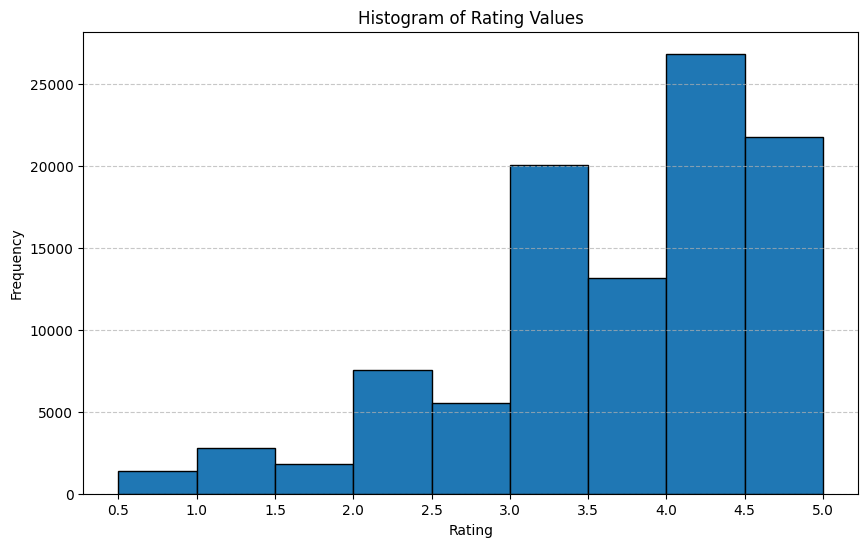

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(rt['rating'], bins=np.arange(0.5, 5.5, 0.5), edgecolor='black')
plt.title('Histogram of Rating Values')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(np.arange(0.5, 5.5, 0.5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The histogram of rating values shows a right-skewed distribution, with the majority of ratings concentrated in the higher range (4.0–5.0). This suggests that users generally provide positive feedback, potentially indicating satisfaction or a tendency to rate items they already like. The lower end of the scale (0.5–2.0) has significantly fewer entries, showing a reluctance to give low ratings. The middle range (2.5–3.5) is relatively flat, suggesting that neutral ratings are less common. Overall, the distribution hints at a positive rating bias, where users are more inclined to give favorable reviews.

**C:Plot the distribution of the number of ratings received among movies:**

The X-axis should be the movie index ordered by decreasing frequency and the Y -axis should be the number of ratings the movie has received; ties can broken in any way. A monotonically decreasing trend is expected.

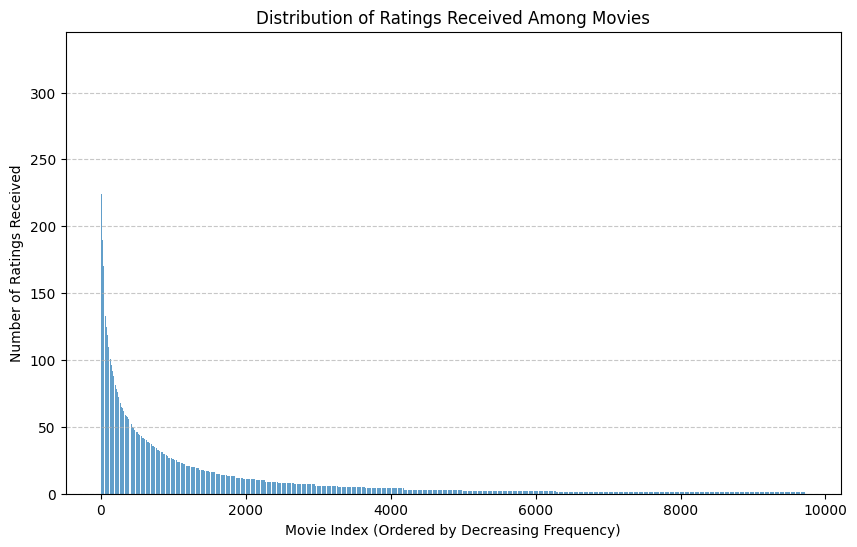

In [ ]:
movie_ratings_count = rt.groupby('movieId').size().sort_values(ascending=False)

# plt.figure(figsize=(10, 6))
# plt.plot(range(len(movie_ratings_count)), movie_ratings_count, marker='.',  markersize=10)
# plt.title('Distribution of Ratings Received Among Movies')
# plt.xlabel('Movie Index (Ordered by Decreasing Frequency)')
# plt.ylabel('Number of Ratings Received')
# plt.show()

plt.figure(figsize=(10, 6))
plt.bar(range(len(movie_ratings_count)), movie_ratings_count, alpha=0.7)
plt.xlabel('Movie Index (Ordered by Decreasing Frequency)')
plt.ylabel('Number of Ratings Received')
plt.title('Distribution of Ratings Received Among Movies')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**D: Plot the distribution of ratings among users:**

The X-axis should be the user index ordered by decreasing frequency and the Y -axis should be the number of movies the user has rated. The requirement of the plot is similar to that in Question C.


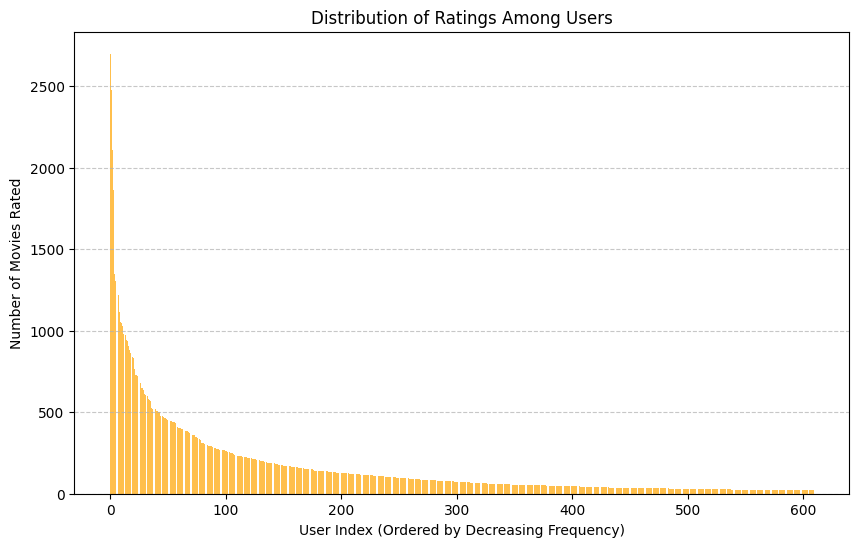

In [ ]:
user_ratings_count = rt.groupby('userId').size().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(range(len(user_ratings_count)), user_ratings_count, color='orange', alpha=0.7)
plt.title('Distribution of Ratings Among Users')
plt.xlabel('User Index (Ordered by Decreasing Frequency)')
plt.ylabel('Number of Movies Rated')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**E: Discuss the salient features of the distributions from Questions C,D and their implications for the recommendation process.** \\

In part C, the distribution of ratings received among movies exhibits a monotonically decreasing trend, indicating that only a handful of movies accumulate a large number of ratings, while the majority receive relatively few. This reflects the popularity bias, where a select few movies are extremely popular and widely watched. The long tail of the distribution highlights the existence of a diverse set of niche movies that, despite being less popular, still attract a specific audience. This phenomenon suggests that while mainstream movies dominate user engagement, there is significant value in catering to diverse user preferences through the discovery of niche content.

In part D, a similar monotonically decreasing trend is observed in the distribution of ratings among users. Only a few users are highly active, providing numerous ratings, while the majority rate relatively few movies. This indicates a disparity in user engagement levels, where a small subset of users heavily influences the data available for recommendations, while many users provide insufficient feedback, posing a cold start problem for user personalization.

These patterns present challenges for recommendation systems, as they must strike a balance between promoting popular content and ensuring the discovery of niche movies that align with individual preferences. Additionally, systems must account for the variability in user engagement, providing relevant suggestions for both highly active and infrequent users. Addressing these issues requires the integration of hybrid recommendation approaches, leveraging both collaborative filtering for popular content and content-based filtering to surface niche items, thereby offering a comprehensive and satisfying user experience.

**F: Compute the variance of the rating values received by each movie:**

Bin the variance values into intervals of width 0.5 and use the binned variance values as the horizontal axis. Count the number of movies with variance values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the resulting histogram.

count    6278.000000
mean        0.857169
std         0.795839
min         0.000000
25%         0.395833
50%         0.702111
75%         1.105310
max        10.125000
Name: rating, dtype: float64


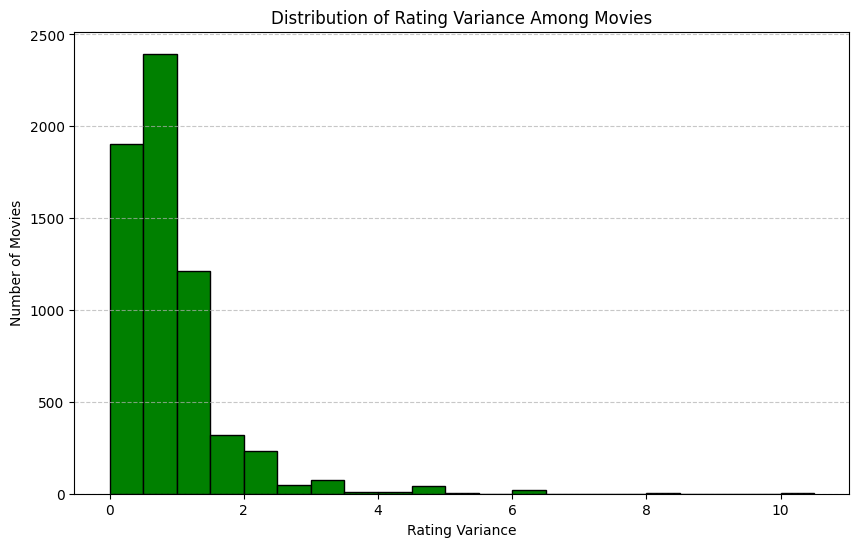

In [ ]:
movie_rating_variance = rt.groupby('movieId')['rating'].var().dropna()
print (movie_rating_variance.describe())

# Plotting the histogram of movie rating variances
plt.figure(figsize=(10, 6))
plt.hist(movie_rating_variance, bins=np.arange(0, movie_rating_variance.max() + 0.5, 0.5), edgecolor='black', color='green')
plt.title('Distribution of Rating Variance Among Movies')
plt.xlabel('Rating Variance')
plt.ylabel('Number of Movies')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



The histogram displays a right-skewed distribution, where the majority of movies have low rating variance, clustered between 0 and 1. This indicates that most movies receive consistent ratings from users. The long tail extending to the right shows that only a few movies have high variance, suggesting polarizing opinions among viewers for those particular movies.

## QUESTION 2:

**Understanding the Pearson Correlation Coefficient:** \\
A Write down the formula for $μ_u$ in terms of $I_u$ and $r_{uk}$;

B In plain words, explain the meaning of $I_u ∩ I_v$. Can $I_u ∩ I_v = ∅$? (Hint: Rating matrix R is sparse)

**Answer:**

A: The formula is

$\mu_u = \frac{1}{|I_u|} \sum_{k \in I_u} r_{uk}$

B: The set $I_u \cap I_v$ represents the items that both users $u$ and $v$ have rated. If $I_u \cap I_v = \emptyset$, it indicates that there are no items commonly rated by both users. This situation often arises in a \textbf{sparse rating matrix}, where the majority of ratings are missing, and users typically rate different sets of items, resulting in no overlap in their rated items.


## QUESTION 3:

**Understanding the Prediction function:** Can you explain the reason behind mean-centering the raw ratings $r_{vj}-μ_v$ in the prediction function? (Hint: Consider users who either rate all items highly or rate all items poorly and the impact of these users on the prediction function.)

**Answers:**
Mean-centering the raw ratings $r_{vj} - \mu_v$ in the prediction function is essential for correcting biases caused by users who consistently give higher or lower ratings. By normalizing the ratings, this process removes the impact of individual rating tendencies. Without mean-centering, users with consistently high or low rating patterns could unduly influence predictions, resulting in inaccuracies. This adjustment allows the prediction function to emphasize the relative differences in ratings by considering how a user's ratings differ from their average. As a result, predictions become more accurate and fair, accommodating users with varying rating behaviors.


## QUESTION 4:

Design a k-NN collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis).

In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import KNNWithMeans

reader = Reader(rating_scale=(0.5, 5))

data = Dataset.load_from_df(rt[['userId', 'movieId', 'rating']], reader)

# Define the range of 'k' values for KNN (from 2 to 100 with steps of 2)
k_values = range(2, 101, 2)
# Initialize lists to store average RMSE and MAE values for each 'k'
avg_rmse = []
avg_mae = []

for k in k_values:
    algo = KNNWithMeans(k=k, sim_options={'name': 'pearson', 'user_based': True})
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)

    avg_rmse.append(np.mean(results['test_rmse']))
    avg_mae.append(np.mean(results['test_mae']))

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

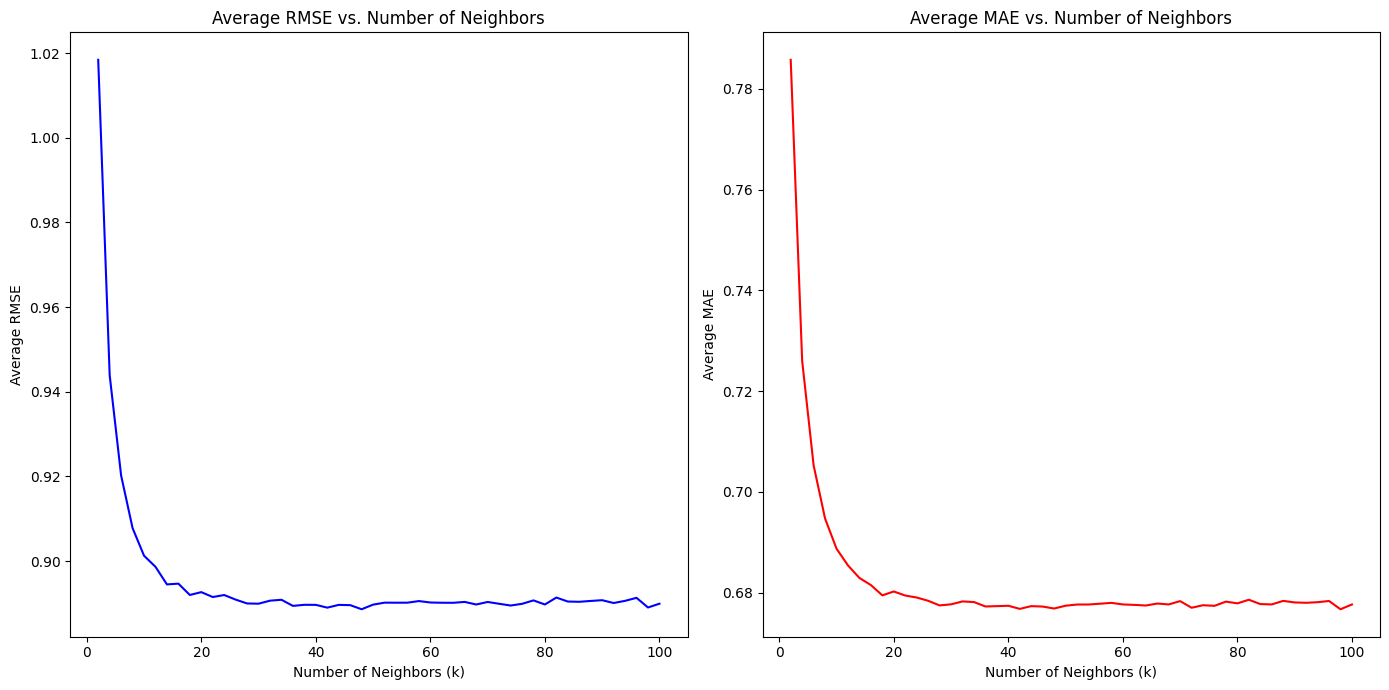

In [ ]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(k_values, avg_rmse, color='b')
plt.title('Average RMSE vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average RMSE')

plt.subplot(1, 2, 2)
plt.plot(k_values, avg_mae, color='r')
plt.title('Average MAE vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average MAE')

plt.tight_layout()
plt.show()

## QUESTION 5:

Use the plot from question 4, to find a ’minimum k’. Note: The term ’minimum k’ in this context means that increasing k above the minimum value would not result in a significant decrease in average RMSE or average MAE. If you get the plot correct, then ’minimum k’ would correspond to the k value for which average RMSE and average MAE converges to a steady-state value. Please report the steady state values of average RMSE and average MAE.

In [ ]:


# Finding the 'minimum k' where RMSE and MAE converge (steady-state detection)
rmse_diffs = np.diff(avg_rmse)
mae_diffs = np.diff(avg_mae)

# Define a threshold for 'no significant improvement'
threshold = 0.001  # Adjust this if needed

# Find the first k where RMSE and MAE improvements are below the threshold
min_k_rmse = next((k_values[i + 1] for i, diff in enumerate(rmse_diffs) if abs(diff) < threshold), None)
min_k_mae = next((k_values[i + 1] for i, diff in enumerate(mae_diffs) if abs(diff) < threshold), None)

# Final 'minimum k' is the larger one to ensure both RMSE and MAE have stabilized
minimum_k = max(min_k_rmse, min_k_mae)

steady_state_rmse = avg_rmse[k_values.index(minimum_k)]
steady_state_mae = avg_mae[k_values.index(minimum_k)]

print(f"Minimum k (steady state): {minimum_k}")
print(f"Steady-state Average RMSE: {steady_state_rmse:.4f}")
print(f"Steady-state Average MAE: {steady_state_mae:.4f}")

Minimum k (steady state): 20
Steady-state Average RMSE: 0.8926
Steady-state Average MAE: 0.6802


The Minimum K at steady state is 20, and Steady-state Average RMSE: 0.8926, Steady-state Average MAE: 0.6802

## QUESTION 6:

Within EACH of the 3 trimmed subsets in the dataset, design (train and validate):
A k-NN collaborative filter on the ratings of the movies (i.e Popular, Unpopular or High-Variance) and evaluate each of the three models’ performance using 10-fold cross validation:

* Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.

* Plot the ROC curves for the k-NN collaborative filters for threshold values [2.5, 3, 3.5, 4]. These thresholds are applied only on the ground truth labels in held-out validation set. For each of the plots, also report the area under the curve (AUC) value. You should have 4 × 4 plots in this section (4 trimming options – including no trimming times 4 thresholds) - all thresholds can be condensed into one plot per trimming option yielding only 4 plots.

In [ ]:
from surprise import Dataset, Reader, KNNWithMeans
from surprise.model_selection import cross_validate, KFold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# --- DATA TRIMMING (As provided) ---
# Assuming rt is your DataFrame with ['userId', 'movieId', 'rating']
reader = Reader(rating_scale=(0.5, 5))

# No trimming
no_trimmed_data = Dataset.load_from_df(rt[['userId', 'movieId', 'rating']], reader)

# Popular movies (rated more than 2 times)
popular_movies = rt.groupby('movieId')['rating'].count() > 2
popular_trimmed_data = rt[rt['movieId'].isin(popular_movies[popular_movies].index)]
popular_trimmed_data = Dataset.load_from_df(popular_trimmed_data[['userId', 'movieId', 'rating']], reader)

# Unpopular movies (rated 2 times or less)
unpopular_movies = rt.groupby('movieId')['rating'].count() <= 2
unpopular_trimmed_data = rt[rt['movieId'].isin(unpopular_movies[unpopular_movies].index)]
unpopular_trimmed_data = Dataset.load_from_df(unpopular_trimmed_data[['userId', 'movieId', 'rating']], reader)

# High variance movies (variance >= 2 with at least 5 ratings)
high_variance_movies = rt.groupby('movieId').filter(lambda x: len(x) >= 5)
high_variance_movies = high_variance_movies.groupby('movieId')['rating'].var() >= 2
high_variance_trimmed_data = rt[rt['movieId'].isin(high_variance_movies[high_variance_movies].index)]
high_variance_trimmed_data = Dataset.load_from_df(high_variance_trimmed_data[['userId', 'movieId', 'rating']], reader)

# --- Datasets dictionary ---
trimmed_datasets = {
    "No Trimming": no_trimmed_data,
    "Popular Movies": popular_trimmed_data,
    "Unpopular Movies": unpopular_trimmed_data,
    "High Variance Movies": high_variance_trimmed_data
}

# --- Parameters ---
ks = np.arange(2, 101, 2)
thresholds = [2.5, 3, 3.5, 4]

In [ ]:
# --- RMSE Calculation ---
def calculate_rmse(dataset, ks):
    rmse_values = []
    for k in ks:
        algo = KNNWithMeans(k=k, sim_options={'name': 'pearson_baseline', 'user_based': True})
        results = cross_validate(algo, dataset, measures=['RMSE'], cv=10, verbose=False)
        rmse_values.append(np.mean(results['test_rmse']))
    return rmse_values

# --- Plot RMSE ---
def plot_rmse(ks, rmse_values, title):
    min_rmse = np.min(rmse_values)
    min_k = ks[np.argmin(rmse_values)]
    plt.plot(ks, rmse_values, label=f'{title} (Min RMSE={min_rmse:.4f} at k={min_k})')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Average RMSE')
    plt.title(f'RMSE vs k for {title}')
    plt.legend()
    plt.grid(True)
    print(f'{title} - Minimum RMSE: {min_rmse:.4f} at k={min_k}')

# --- ROC Curves ---
def plot_roc_curves(predictions, thresholds, title):
    plt.title(f'ROC Curve - {title}')
    for threshold in thresholds:
        y_true = [1 if pred.r_ui >= threshold else 0 for pred in predictions]
        y_scores = [pred.est for pred in predictions]
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Threshold={threshold} (AUC={roc_auc:.2f})')
        print(f'{title} - Threshold {threshold}: AUC={roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)

Streaming output truncated to the last 5000 lines.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating bi

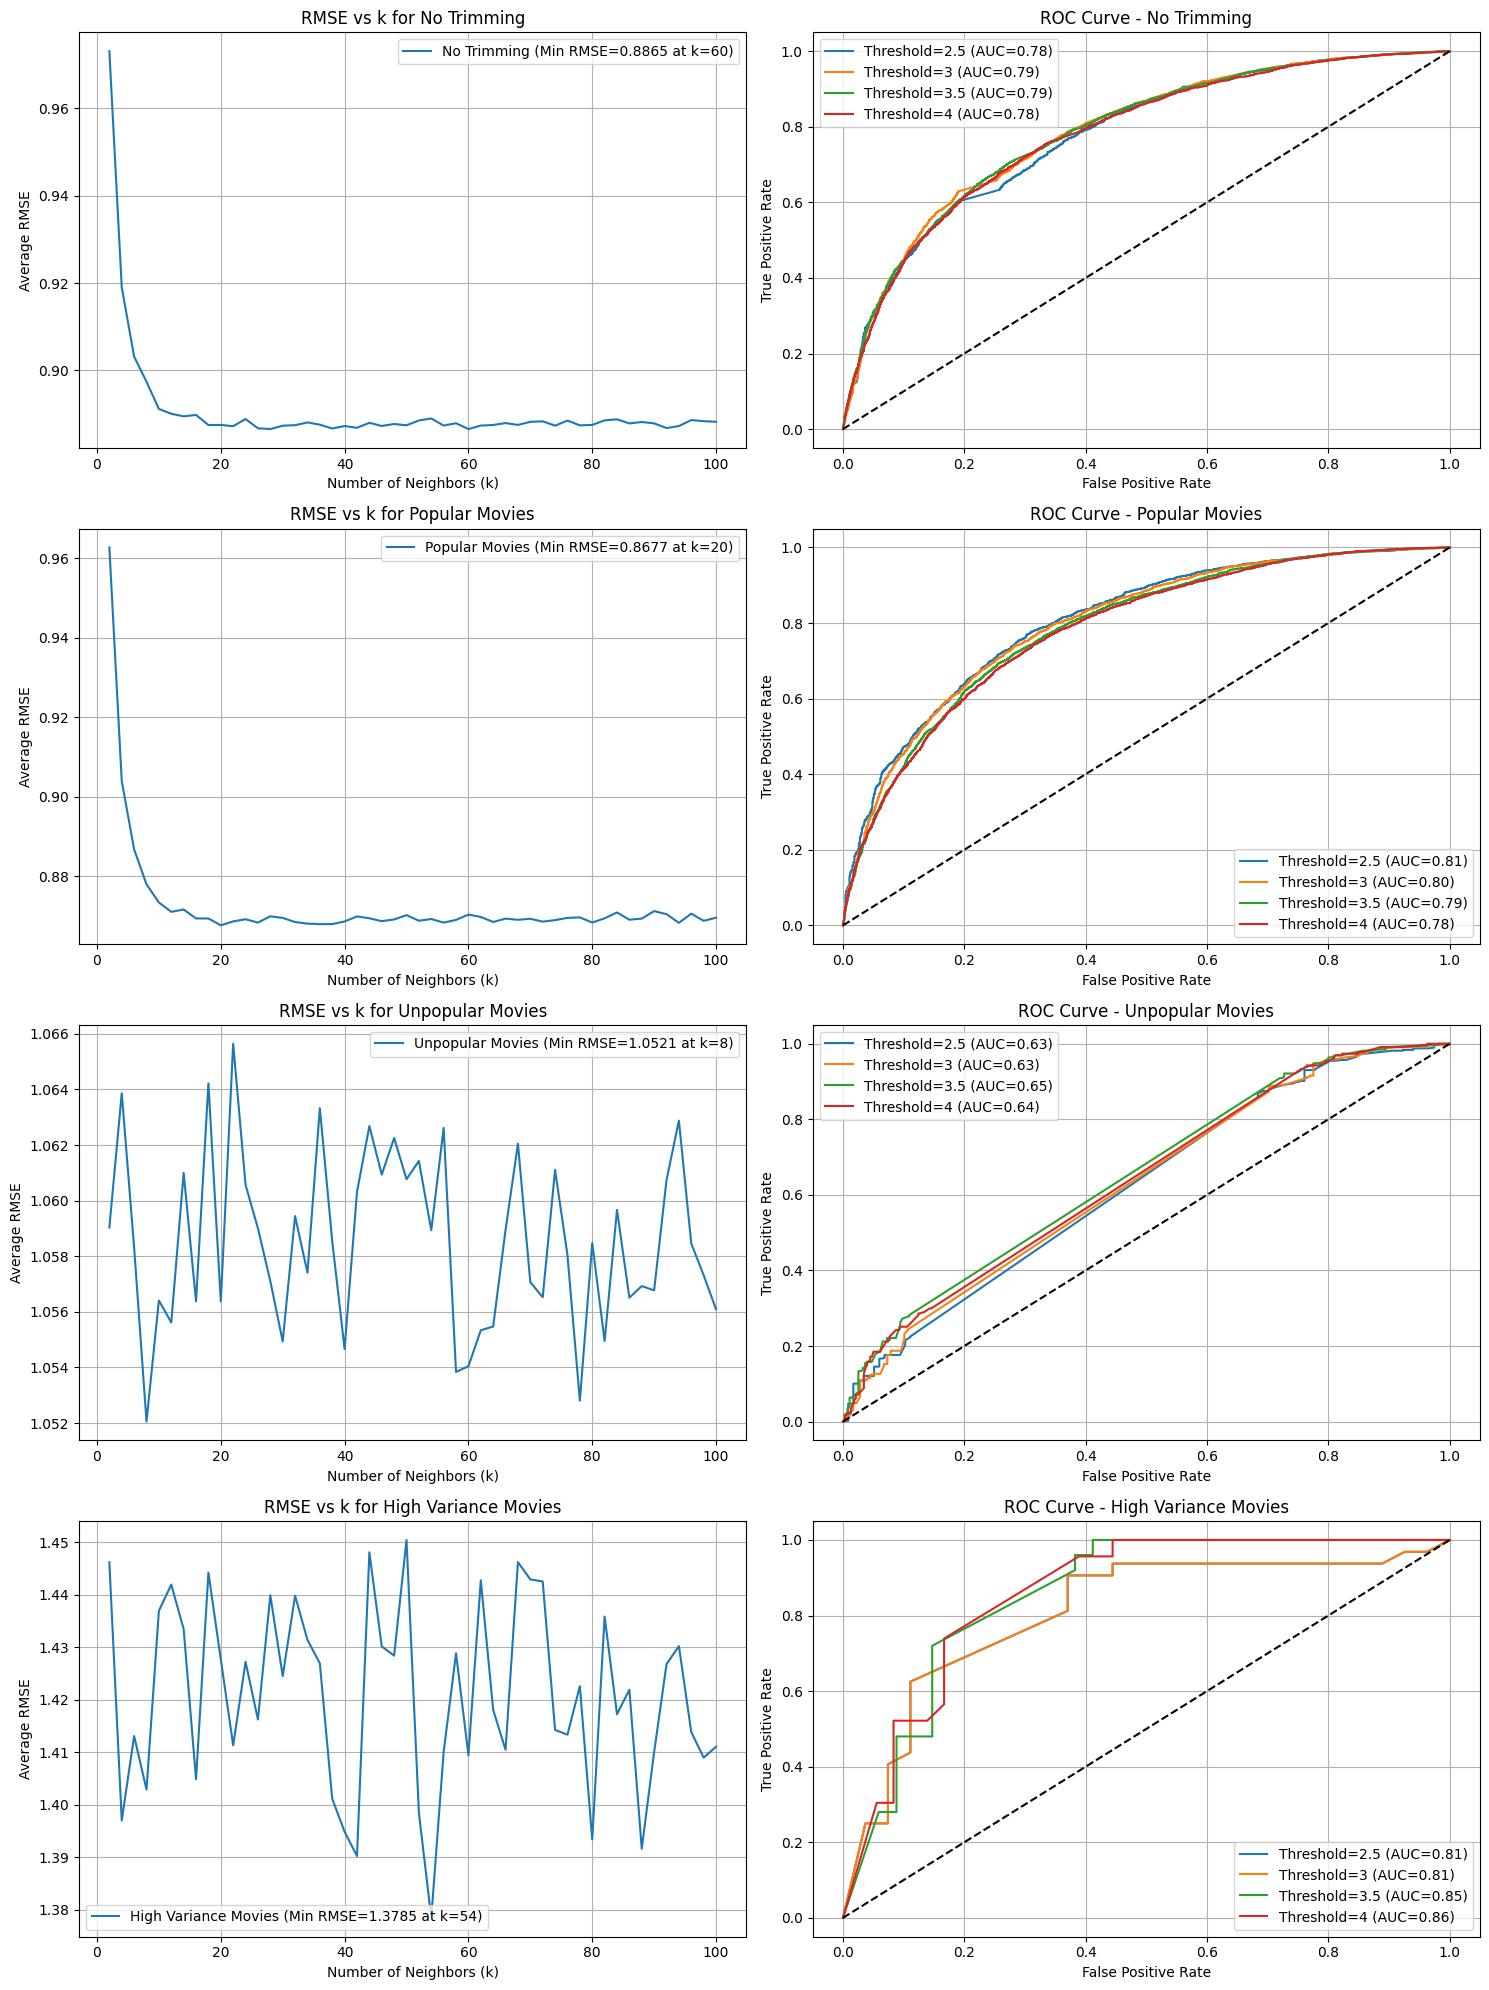

In [ ]:
plt.figure(figsize=(15, 20))
plot_idx = 1

for title, dataset in trimmed_datasets.items():
    print(f"\n=== {title} Dataset ===")
    # 1) RMSE vs k
    rmse_values = calculate_rmse(dataset, ks)
    plt.subplot(4, 2, plot_idx)
    plot_rmse(ks, rmse_values, title)
    plot_idx += 1

    # 2) ROC Curves (Train best model and test)
    best_k = ks[np.argmin(rmse_values)]
    algo = KNNWithMeans(k=best_k, sim_options={'name': 'pearson_baseline', 'user_based': True})

    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    for trainset, testset in kf.split(dataset):
        algo.fit(trainset)
        predictions = algo.test(testset)
        break  # Use first fold for ROC plots

    plt.subplot(4, 2, plot_idx)
    plot_roc_curves(predictions, thresholds, title)
    plot_idx += 1

plt.tight_layout()
plt.show()


## QUESTION 7: Understanding the NMF cost function:
 Is the optimization problem given by equation 5 [$\min_{U,V} \sum_{i=1}^{m} \sum_{j=1}^{n} W_{ij} \left( r_{ij} - (UV^T)_{ij} \right)^2$] convex? Consider the optimization problem given by equation 5. For U fixed, formulate it as a least-squares problem.

 **Answer:**
It is a not convex problem. \\

The optimization problem is generally not convex in both $U$ and $V$ simultaneously because the objective function involves a bilinear term $UV^T$.


When $U$ is fixed, we can consider the problem as a least-squares problem. In this case, we treat $U$ as a constant, and the objective function becomes a quadratic function of $V$. The problem becomes:

$\underset{V}{\min} \sum_{i=1}^{m} \sum_{j=1}^{n} W_{ij} \cdot \left( \text{rating}_{ij} - (UV^T)_{ij} \right)^2, \min_{V} \| W_i^{1/2} (R_i - V U_i^T) \|_2^2$


This is a standard least-squares problem.



## QUESTION 8:
Designing the NMF Collaborative Filter:

A

Design a NMF-based collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. If NMF takes too long, you can increase the step size. Increasing it too much will result in poorer granularity
in your results. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis). For solving this question, use the default value for the regularization parameter.


k=2
rmse=1.1435188791158633
mae=0.9610735633394164

k=4
rmse=1.0377897318427518
mae=0.8476193856455645

k=6
rmse=0.9818544407334914
mae=0.7853730496997663

k=8
rmse=0.9483191707623654
mae=0.7477926640117157

k=10
rmse=0.9313782829590759
mae=0.7257725701955176

k=12
rmse=0.9206104435253095
mae=0.7106773447708752

k=14
rmse=0.9173352484407593
mae=0.7038110616819651

k=16
rmse=0.9130498960252618
mae=0.6985325482278018

k=18
rmse=0.9133485456851173
mae=0.6948574408155579

k=20
rmse=0.912647102234833
mae=0.6932044278241123

k=22
rmse=0.9181493528235738
mae=0.6949298094959587

k=24
rmse=0.9198794874213491
mae=0.6951411447937657

k=26
rmse=0.9223074499100694
mae=0.6965893218362821

k=28
rmse=0.9257935259564338
mae=0.6976388173240442

k=30
rmse=0.92920425011008
mae=0.7002398845262932

k=32
rmse=0.9353393932670826
mae=0.7047479495061488

k=34
rmse=0.9374758994780279
mae=0.7062256489921198

k=36
rmse=0.9418938318911039
mae=0.7089632003907032

k=38
rmse=0.9459520286941128
mae=0.7120771711129803



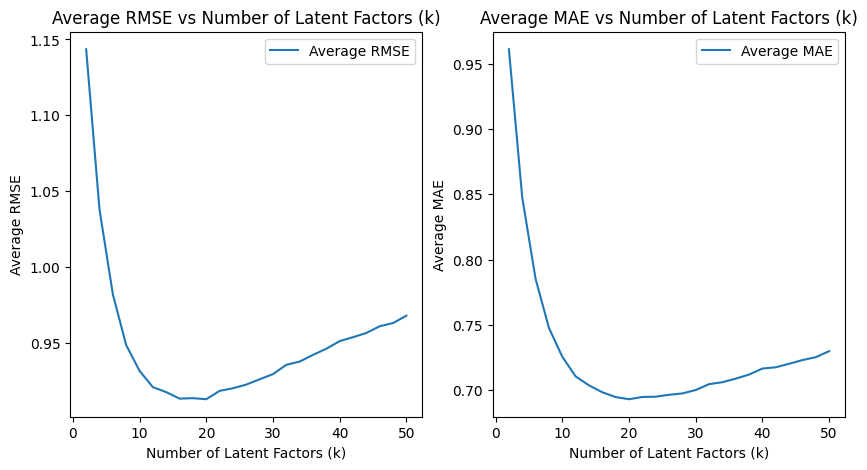

In [ ]:
from surprise import NMF
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt

#    Load the data into a Surprise Dataset
data = no_trimmed_data

#    Sweep k from 2 to 50 in step sizes of 2
k_values = list(range(2, 51, 2))

#    Lists to store average RMSE and MAE for each k
avg_rmse_values = []
avg_mae_values = []

for k in k_values:
    #   NMF collaborative filter
    algo = NMF(n_factors=k)

    #   10-fold cross-validation
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)

    #   RMSE and MAE calculation
    avg_rmse = np.mean(results['test_rmse'])
    avg_mae = np.mean(results['test_mae'])
    avg_rmse_values.append(avg_rmse)
    avg_mae_values.append(avg_mae)
    print(f"k={k}\nrmse={avg_rmse}\nmae={avg_mae}\n")

#   RMSE against k
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, avg_rmse_values, label='Average RMSE')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')
plt.title('Average RMSE vs Number of Latent Factors (k)')
plt.legend()


#   MAE against k
plt.subplot(1, 2, 2)
plt.plot(k_values, avg_mae_values, label='Average MAE')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average MAE')
plt.title('Average MAE vs Number of Latent Factors (k)')
plt.legend()
plt.show()



B

Use the plot from the previous part to find the optimal number of latent factors. Optimal
number of latent factors is the value of k that gives the minimum average RMSE or the
minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal
number of latent factors same as the number of movie genres?



In [ ]:

min_rmse = np.min(np.array(avg_rmse_values))
min_rmse_k = np.argmin(np.array(avg_rmse_values))
min_rmse_k = k_values[min_rmse_k]
min_mae = np.min(np.array(avg_mae_values))
min_mae_k = np.argmin(np.array(avg_mae_values))
min_mae_k = k_values[min_mae_k]
print(f"Number of Latent Factors k for RMSE:{min_rmse_k}, minimize RMSE={min_rmse}\n")
print(f"Number of Latent Factors k for MAE:{min_mae_k}, minimize MAE={min_mae}\n")

Number of Latent Factors k for RMSE:20, minimize RMSE=0.912647102234833

Number of Latent Factors k for MAE:20, minimize MAE=0.6932044278241123



In [ ]:
genres_dict = []
for i in mv['genres']:
  genres_dict.extend(i.split("|"))
genres_dict = set(genres_dict)
print(f"Genres:{genres_dict}")
print(f"Number of Gneres:{len(genres_dict)}")

Genres:{'War', 'Romance', 'IMAX', 'Documentary', 'Sci-Fi', '(no genres listed)', 'Musical', 'Western', 'Action', 'Animation', 'Fantasy', 'Comedy', 'Thriller', 'Horror', 'Drama', 'Film-Noir', 'Children', 'Adventure', 'Crime', 'Mystery'}
Number of Gneres:20


The optimal number of latent factors based on minimum average RMSE is 20, while the optimal number based on minimum average MAE is 20. There are 20 genres of movies in the dataset. The fact that the optimal number is same to the number of genres suggests that the model may be discovering latent factors that are similar to the genre categories. This alignment with the number of genres indicates that the model is capturing information related to the movie genres, and the choice of latent factors is in line with the underlying structure of the data.

C

Performance on trimmed dataset subsets: For each of Popular, Unpopular and High-Variance subsets – Design a NMF collaborative filter for each trimmed subset and evaluate its performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds.– Plot average RMSE (Y-axis) against k  (X-axis); item Report the minimum average RMSE.

* Plot the ROC curves for the NMF-based collaborative filter and also report the area under the curve (AUC) value as done in Question 6.

Trimming Option: No Trimming
k=2 | Average RMSE=1.1467
k=4 | Average RMSE=1.0422
k=6 | Average RMSE=0.9827
k=8 | Average RMSE=0.9502
k=10 | Average RMSE=0.9313
k=12 | Average RMSE=0.9217
k=14 | Average RMSE=0.9169
k=16 | Average RMSE=0.9119
k=18 | Average RMSE=0.9115
k=20 | Average RMSE=0.9149
k=22 | Average RMSE=0.9172
k=24 | Average RMSE=0.9219
k=26 | Average RMSE=0.9223
k=28 | Average RMSE=0.9273
k=30 | Average RMSE=0.9295
k=32 | Average RMSE=0.9349
k=34 | Average RMSE=0.9388
k=36 | Average RMSE=0.9413
k=38 | Average RMSE=0.9451
k=40 | Average RMSE=0.9498
k=42 | Average RMSE=0.9541
k=44 | Average RMSE=0.9554
k=46 | Average RMSE=0.9596
k=48 | Average RMSE=0.9638
k=50 | Average RMSE=0.9675
Trimming Option: Popular Movies
k=2 | Average RMSE=1.1390
k=4 | Average RMSE=1.0261
k=6 | Average RMSE=0.9664
k=8 | Average RMSE=0.9310
k=10 | Average RMSE=0.9114
k=12 | Average RMSE=0.9006
k=14 | Average RMSE=0.8939
k=16 | Average RMSE=0.8928
k=18 | Average RMSE=0.8934
k=20 | Average RMSE=0.8947
k=

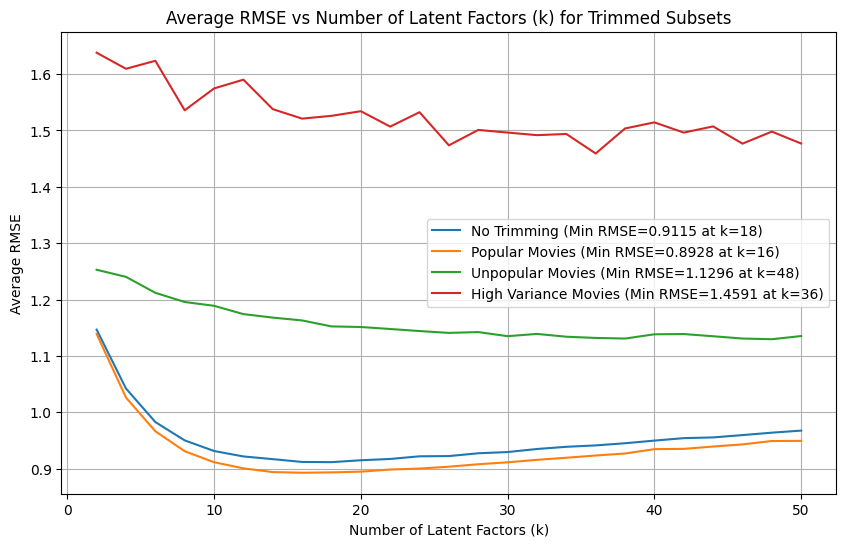

In [ ]:
k_values = list(range(2, 51, 2))

# --- Main Execution ---
plt.figure(figsize=(10, 6))

for trimming_option, trimmed_data in trimmed_datasets.items():
    print(f"Trimming Option: {trimming_option}")

    # Average RMSE storage
    avg_rmse_values = []

    # Sweep k values
    for k in k_values:
        # NMF collaborative filter
        algo = NMF(n_factors=k)

        # 10-fold cross-validation
        results = cross_validate(algo, trimmed_data, measures=['RMSE'], cv=10, verbose=False)

        # Average RMSE calculation
        avg_rmse = np.mean(results['test_rmse'])
        print(f"k={k} | Average RMSE={avg_rmse:.4f}")
        avg_rmse_values.append(avg_rmse)

    # Plot Average RMSE vs k
    plt.plot(k_values, avg_rmse_values, label=f'{trimming_option} (Min RMSE={min(avg_rmse_values):.4f} at k={k_values[np.argmin(avg_rmse_values)]})')

# Display final plot
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')
plt.title('Average RMSE vs Number of Latent Factors (k) for Trimmed Subsets')
plt.legend()
plt.grid(True)
plt.show()


## QUESTION 9:
Interpreting the NMF model: Perform Non-negative matrix factorization on the ratings matrix R to obtain the factor matrices U and V , where U represents the user-latent factors interaction and V represents the movie-latent factors interaction (use k = 20). For each column of V , sort the movies in descending order and report the genres of the top 10 movies. Do the top 10 movies belong to a particular or a small collection of genre? Is there a connection between the latent factors and the movie genres?

In [ ]:
from surprise import NMF
import numpy as np

#   surprise reader
reader = Reader(rating_scale=(0, 5))
data = no_trimmed_data

#   NMF collaborative filter(k=20)
k = 20
algo_nmf = NMF(n_factors=k, random_state=42)

#   Fit the model
trainset = data.build_full_trainset()
algo_nmf.fit(trainset)

#   Matrices U and V
U = algo_nmf.pu
V = algo_nmf.qi

#   Iteration
for latent_factor_index in range(k):
    #   Get the movies sorted by their influence on the current latent factor
    movies_sorted_by_influence = np.argsort(V[:, latent_factor_index])[::-1]

    #  Display
    top_10_movies = movies_sorted_by_influence[:10]

    print(f'\nLatent Factor {latent_factor_index + 1}:')
    for movie_index in top_10_movies:
        movie_id = trainset.to_raw_iid(movie_index)
        movie_genres = mv[mv['movieId'] == movie_id]['genres'].values[0]
        print(f'Movie ID: {movie_id}, Genres: {movie_genres}')



Latent Factor 1:
Movie ID: 70946, Genres: Fantasy|Horror
Movie ID: 7116, Genres: Horror|Mystery|Thriller
Movie ID: 7564, Genres: Horror
Movie ID: 130634, Genres: Action|Crime|Thriller
Movie ID: 80126, Genres: Drama|Thriller
Movie ID: 2488, Genres: Drama|Horror|Thriller
Movie ID: 3223, Genres: Drama
Movie ID: 1173, Genres: Comedy|Drama
Movie ID: 1606, Genres: Action|Adventure
Movie ID: 4794, Genres: Crime|Horror|Mystery

Latent Factor 2:
Movie ID: 5480, Genres: Children|Comedy
Movie ID: 305, Genres: Comedy
Movie ID: 2149, Genres: Comedy|Fantasy|Horror
Movie ID: 32598, Genres: Comedy|Romance
Movie ID: 1376, Genres: Adventure|Comedy|Sci-Fi
Movie ID: 32892, Genres: Drama|War
Movie ID: 283, Genres: Crime|Drama
Movie ID: 140711, Genres: Action|Comedy|Sci-Fi|Thriller
Movie ID: 54734, Genres: Comedy
Movie ID: 34332, Genres: Action|Adventure|Children|Comedy

Latent Factor 3:
Movie ID: 74754, Genres: Comedy|Drama|Romance
Movie ID: 4863, Genres: Comedy|Crime
Movie ID: 93563, Genres: Action|Sci-F

**Answer:**

Latent factors obtained from the Non-negative Matrix Factorization (NMF) based collaborative filtering model reveal a variety of genre associations. While some factors are strongly linked to a single genre, others cover a broader range of genres. The lack of a direct one-to-one relationship suggests that multiple latent factors contribute to the characterization of movies, reflecting the complexity of user preferences. This observation highlights the model's capacity to uncover intricate patterns by blending genres, effectively representing the subtle aspects of user interests in collaborative filtering.

## QUESTION 10:
Designing the MF Collaborative Filter:

A

Design a MF-based collaborative filter to predict the ratings of the movies in the original dataset and evaluate it’s performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis). For solving this question, use the default value for the regularization parameter.



k=2
Average RMSE:0.8679888988189186
Average RMSE:0.6671911270202102
k=4
Average RMSE:0.8659204707124376
Average RMSE:0.6656049757612303
k=6
Average RMSE:0.8670936979473509
Average RMSE:0.6664676225500636
k=8
Average RMSE:0.8659021368629777
Average RMSE:0.6651700222815881
k=10
Average RMSE:0.8662604207697004
Average RMSE:0.665521406497066
k=12
Average RMSE:0.8647963687163713
Average RMSE:0.6643528681760028
k=14
Average RMSE:0.8657415799727912
Average RMSE:0.6649419707547785
k=16
Average RMSE:0.8669615732471021
Average RMSE:0.6657188279838167
k=18
Average RMSE:0.8670805996767269
Average RMSE:0.665654536568669
k=20
Average RMSE:0.8670837920062231
Average RMSE:0.6655766863683732
k=22
Average RMSE:0.8646744260833641
Average RMSE:0.6634781744600525
k=24
Average RMSE:0.8648735619821325
Average RMSE:0.6639729641586879
k=26
Average RMSE:0.8637859667704351
Average RMSE:0.663017491634003
k=28
Average RMSE:0.8652041026499196
Average RMSE:0.6652171579480977
k=30
Average RMSE:0.8659417549167705
Aver

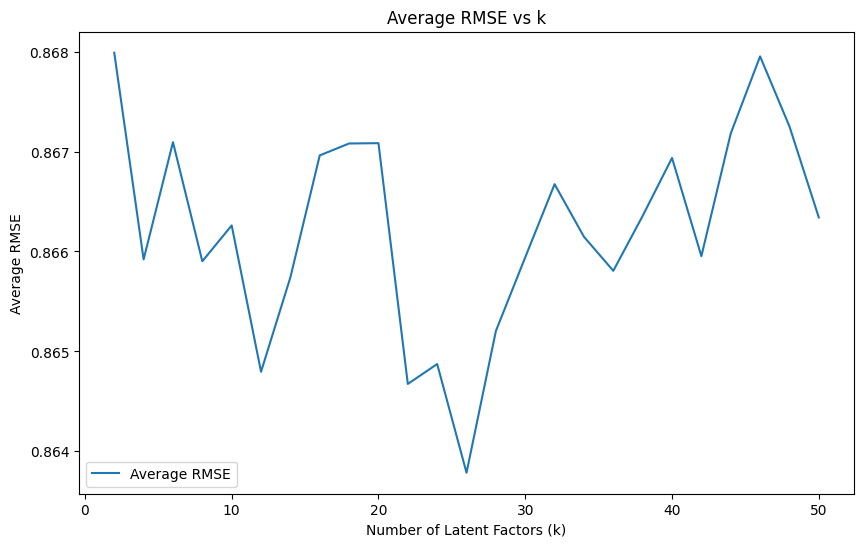

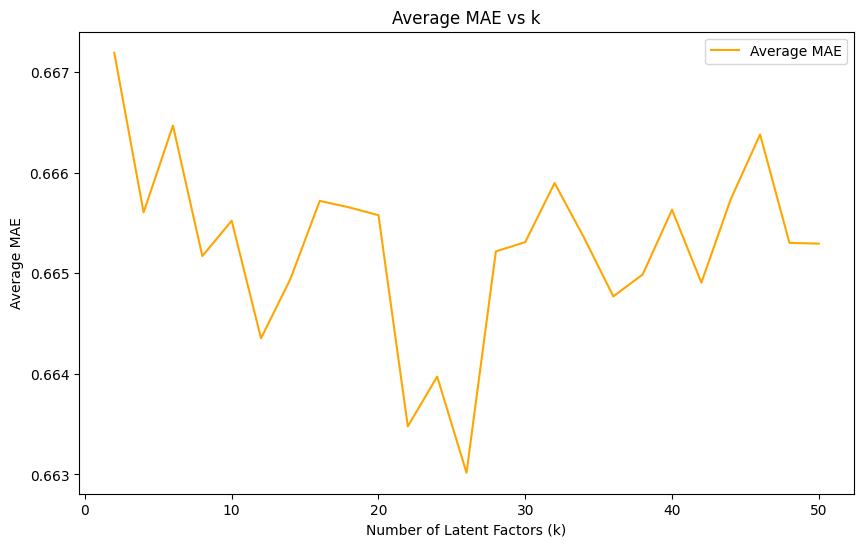

In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import SVD
import matplotlib.pyplot as plt
import numpy as np

reader = Reader(rating_scale=(0, 5))
data = no_trimmed_data

ks = np.arange(2, 51, 2)
rmse_values = []
mae_values = []

for k in ks:
    algo = SVD(n_factors=k, random_state=42)
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    rmse_values.append(np.mean(results['test_rmse']))
    mae_values.append(np.mean(results['test_mae']))
    print(f"k={k}")
    print(f"Average RMSE:{np.mean(results['test_rmse'])}")
    print(f"Average RMSE:{np.mean(results['test_mae'])}")

plt.figure(figsize=(10, 6))
plt.plot(ks, rmse_values, label='Average RMSE')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average RMSE')
plt.title('Average RMSE vs k')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(ks, mae_values, label='Average MAE', color='orange')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average MAE')
plt.title('Average MAE vs k')
plt.legend()
plt.show()


B

Use the plot from the previous part to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?



In [ ]:
# Find the optimal number of latent factors based on the plots
optimal_k_rmse = ks[np.argmin(rmse_values)]
optimal_k_mae = ks[np.argmin(mae_values)]

# Report the minimum average RMSE and MAE
min_avg_rmse = np.min(rmse_values)
min_avg_mae = np.min(mae_values)

print(f"Optimal number of latent factors (RMSE): {optimal_k_rmse}")
print(f"Minimum average RMSE: {min_avg_rmse:.4f}")

print(f"Optimal number of latent factors (MAE): {optimal_k_mae}")
print(f"Minimum average MAE: {min_avg_mae:.4f}")


Optimal number of latent factors (RMSE): 26
Minimum average RMSE: 0.8638
Optimal number of latent factors (MAE): 26
Minimum average MAE: 0.6630


C

Performance on dataset subsets: For each of Popular, Unpopular and High-Variance subsets

- Design a MF collaborative filter for each trimmed subset and evaluate its performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds.
- Plot average RMSE (Y-axis) against k (X-axis); item Report the minimum average RMSE.
- Plot the ROC curves for the MF-based collaborative filter and also report the area under the curve (AUC) value as done in Question6.

Minimum average RMSE (Popular): 0.8547
Minimum average RMSE (Unpopular): 0.8949
Minimum average RMSE (High Variance): 1.4062


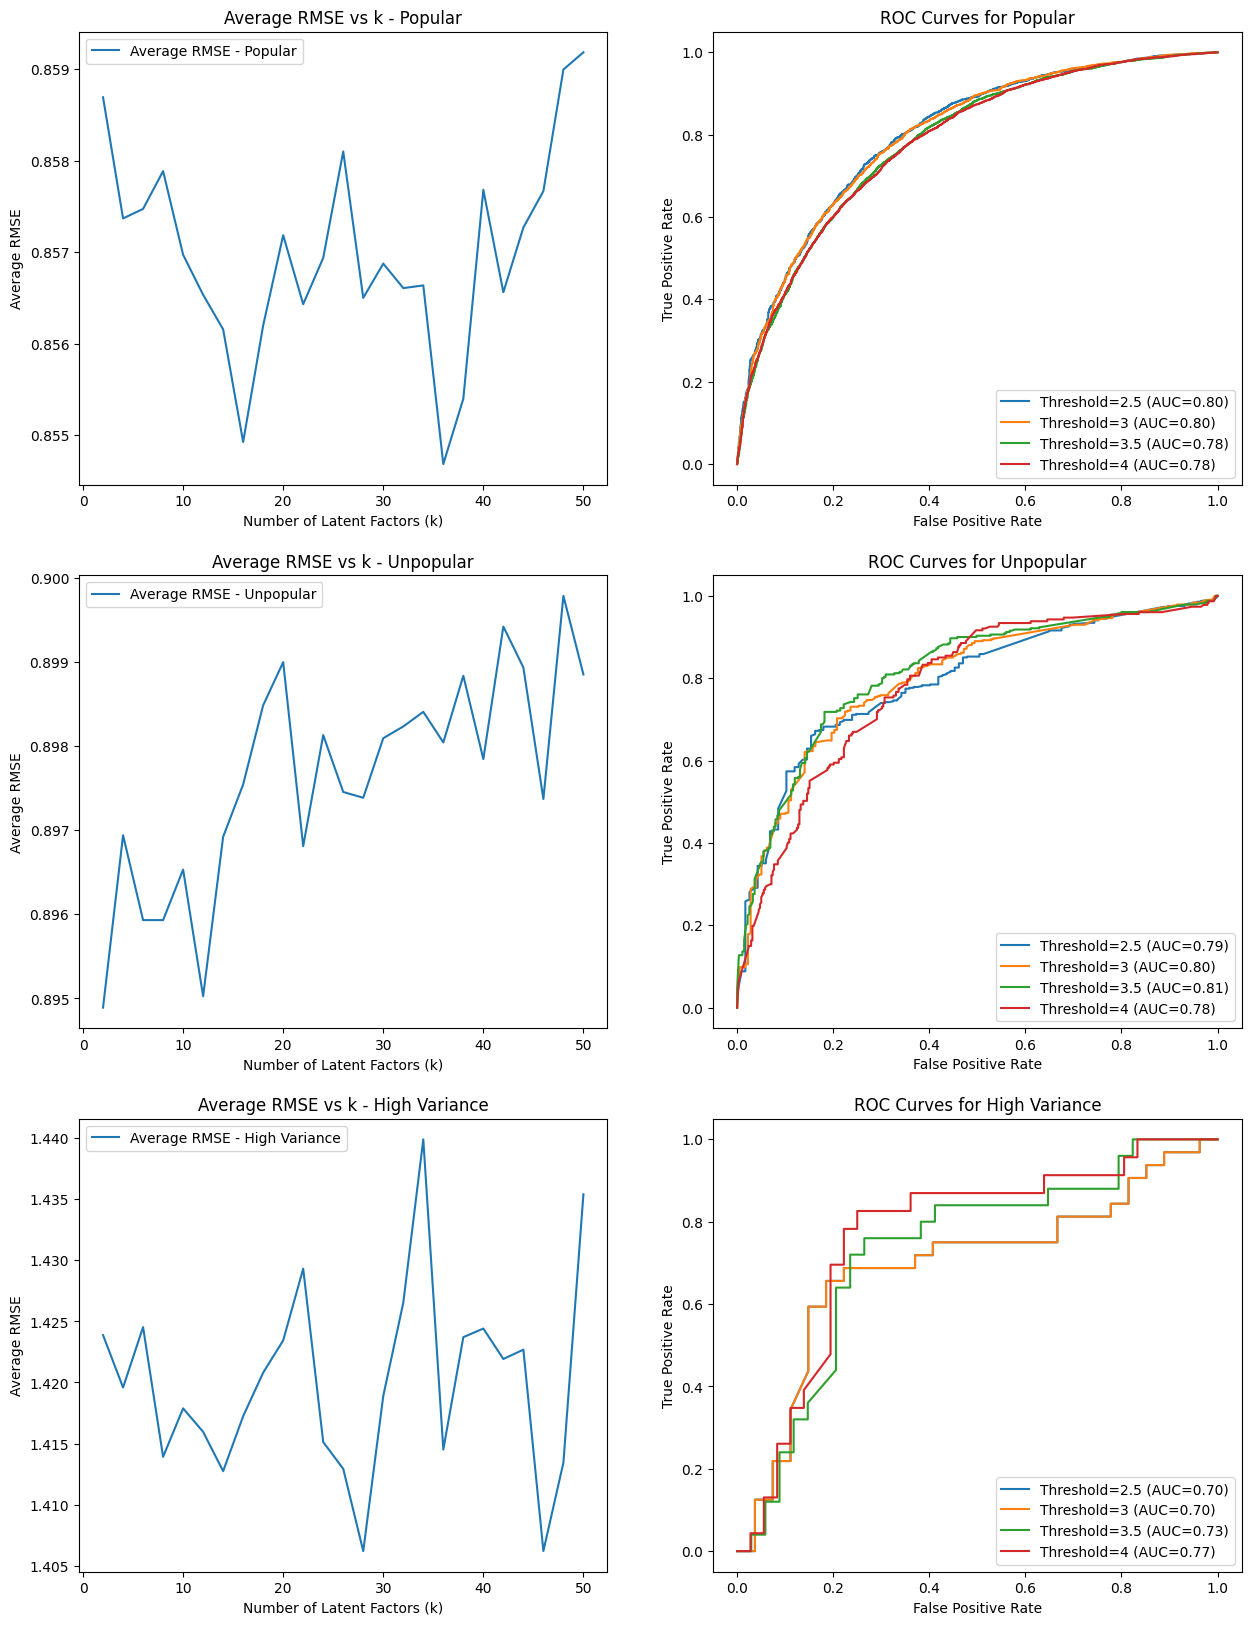

In [ ]:
from surprise import SVD
def plot_roc_curves(predictions, threshold_values, trimming_option):
    fpr_values = []
    tpr_values = []

    for threshold in threshold_values:
        r_ui = [1 if prediction.r_ui >= threshold else 0 for prediction in predictions]
        y_pred = [prediction.est for prediction in predictions]
        fpr, tpr, _ = roc_curve(r_ui, y_pred)
        fpr_values.append(fpr)
        tpr_values.append(tpr)
    global img_idx
    plt.subplot(3, 2, img_idx)
    img_idx += 1
    plt.title(f'ROC Curves for {trimming_option}')

    for i, threshold in enumerate(threshold_values):
        auc_value = auc(fpr_values[i], tpr_values[i])
        plt.plot(fpr_values[i], tpr_values[i], label=f'Threshold={threshold} (AUC={auc_value:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

# Performance on dataset subsets
subset_datasets = {
    'Popular': popular_trimmed_data,
    'Unpopular': unpopular_trimmed_data,
    'High Variance': high_variance_trimmed_data
}

img_idx = 1
plt.figure(figsize=(15, 20))
for subset_name, subset_data in subset_datasets.items():
    subset_rmse_values = []

    for k in ks:
        algo_subset = SVD(n_factors=k, random_state=42)
        results_subset = cross_validate(algo_subset, subset_data, measures=['RMSE'], cv=10, verbose=False)
        subset_rmse_values.append(np.mean(results_subset['test_rmse']))


    plt.subplot(3, 2, img_idx)
    img_idx += 1
    plt.plot(ks, subset_rmse_values, label=f'Average RMSE - {subset_name}')
    plt.xlabel('Number of Latent Factors (k)')
    plt.ylabel('Average RMSE')
    plt.title(f'Average RMSE vs k - {subset_name}')
    plt.legend()

    optimal_k_rmse = ks[np.argmin(subset_rmse_values)]
    algo = SVD(n_factors=optimal_k_rmse, random_state=42)

    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    for trainset, testset in kf.split(subset_data):
        train_data, test_data = trainset, testset
        break

    algo.fit(train_data)

    # Get predictions for ROC curves
    predictions = algo.test(test_data)

    # Plot ROC curves for different threshold values
    plot_roc_curves(predictions, thresholds, subset_name)

    # Report the minimum average RMSE for the subset
    min_avg_rmse_subset = np.min(subset_rmse_values)
    print(f"Minimum average RMSE ({subset_name}): {min_avg_rmse_subset:.4f}")

plt.show()


## QUESTION 11:
Designing a Na ̈ıve Collaborative Filter:

* Design a naive collaborative filter to predict the ratings of the movies in the original dataset and evaluate it’s performance using 10-fold cross validation. Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.

* Performance on dataset subsets: For each of Popular, Unpopular and High-Variance test subsets

  - Design a naive collaborative filter for each trimmed set and evaluate its performance using
  10-fold cross validation.
  - Compute the average RMSE by averaging the RMSE across all 10 folds. Report the
  average RMSE.

In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import KFold
from surprise import accuracy
import numpy as np


# Load the original dataset
reader = Reader(rating_scale=(0, 5))
data = no_trimmed_data

# Define the Naive Collaborative Filter
class NaiveCollaborativeFilter:
    def fit(self, trainset):
      # Naive collaborative filter doesn't require training
      self.trainset = trainset

    def predict(self, uid, iid, r_ui=None, clip=True, verbose=False):
      if clip:
        if self.trainset.knows_user(uid):
          inner_uid = self.trainset.to_inner_uid(uid)
          ratings_for_uid = self.trainset.ur[inner_uid]
          global_mean = np.mean(ratings_for_uid, axis=0)[-1]
        else:
          global_mean = self.trainset.global_mean
      else:
        all_ratings_for_uid = self.trainset.all_ratings()
        ratings_for_uid = [rating for rating in all_ratings_for_uid if rating[0] == uid]
        if len(ratings_for_uid) != 0:
          global_mean = np.mean(ratings_for_uid, axis=0)[-1]
        else:
          global_mean = self.trainset.global_mean

      # Naive prediction function - return the global mean rating
      return uid, iid, r_ui, global_mean, None

# Define a function for 10-fold cross-validation
def cross_validate_naive_filter(data, clip=True):
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    rmse_values = []

    for trainset, testset in kf.split(data):
        naive_filter = NaiveCollaborativeFilter()
        naive_filter.fit(trainset)
        predictions = [naive_filter.predict(uid, iid, r_ui, clip) for uid, iid, r_ui in testset]
        rmse = accuracy.rmse(predictions, verbose=False)
        rmse_values.append(rmse)
    average_rmse = np.mean(rmse_values)
    return average_rmse

# Design and evaluate Naive Collaborative Filter on the original dataset
average_rmse_original = cross_validate_naive_filter(data)

print(f"Average RMSE for the Naive Collaborative Filter on the original dataset: {average_rmse_original:.4f}")

# Performance on dataset subsets
subset_datasets = {
    'Popular': popular_trimmed_data,
    'Unpopular': unpopular_trimmed_data,
    'High Variance': high_variance_trimmed_data
}

for subset_name, subset_data in subset_datasets.items():
    clip=True
    if subset_name != "Popular":
      clip = False
    average_rmse_subset = cross_validate_naive_filter(subset_data, clip)
    print(f"Average RMSE for the Naive Collaborative Filter on {subset_name} subset: {average_rmse_subset:.4f}")


Average RMSE for the Naive Collaborative Filter on the original dataset: 0.9413
Average RMSE for the Naive Collaborative Filter on Popular subset: 0.9377
Average RMSE for the Naive Collaborative Filter on Unpopular subset: 1.2544
Average RMSE for the Naive Collaborative Filter on High Variance subset: 1.6939


## QUESTION 12:
Comparing the most performant models across architecture: Plot the best ROC curves (threshold = 3) for the k-NN, NMF, and MF with bias based collaborative filters in the same figure. Use the figure to compare the performance of the filters in predicting the ratings of the movies.

Evaluating subset: Original
Computing the pearson similarity matrix...
Done computing similarity matrix.


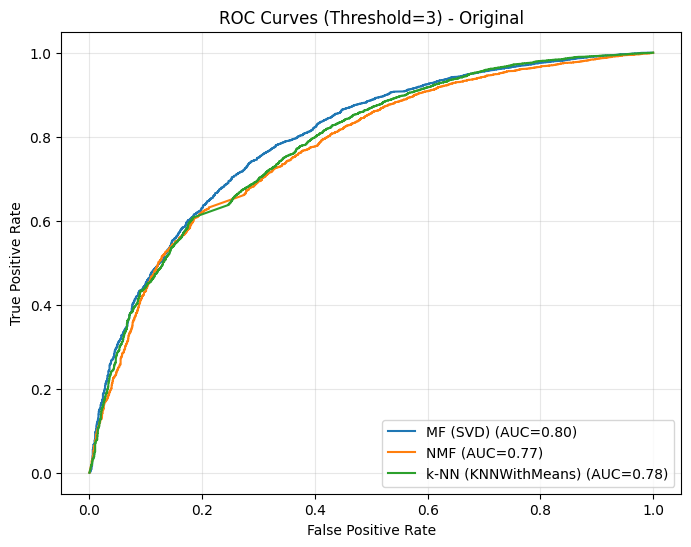

Evaluating subset: Popular
Computing the pearson similarity matrix...
Done computing similarity matrix.


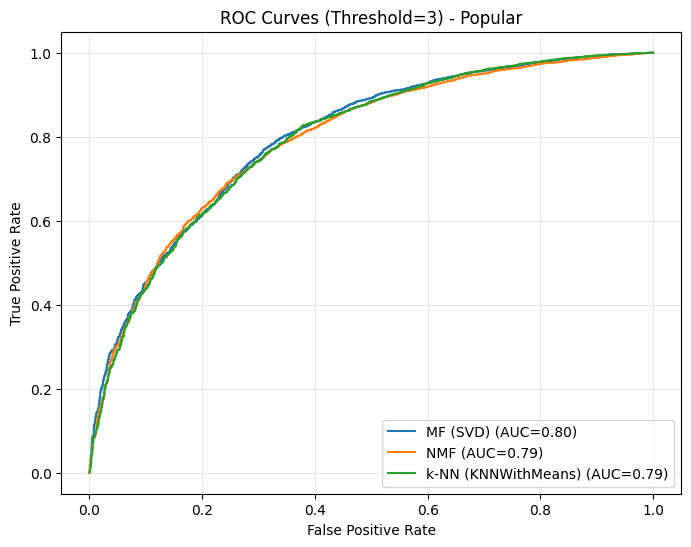

Evaluating subset: Unpopular
Computing the pearson similarity matrix...
Done computing similarity matrix.


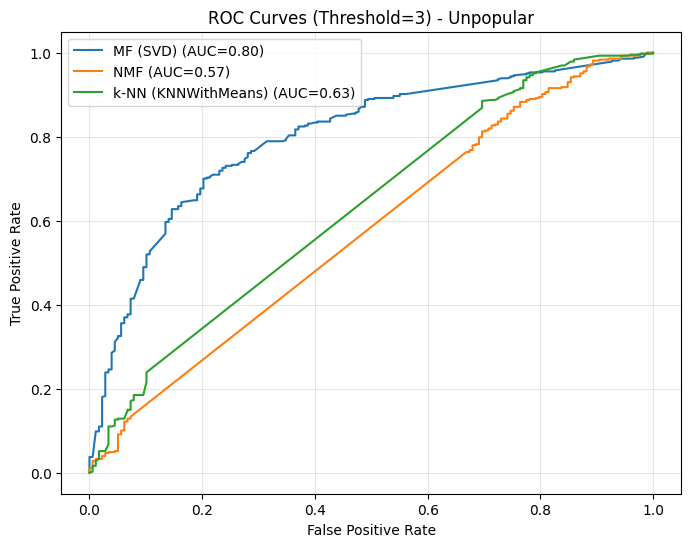

Evaluating subset: High Variance
Computing the pearson similarity matrix...
Done computing similarity matrix.


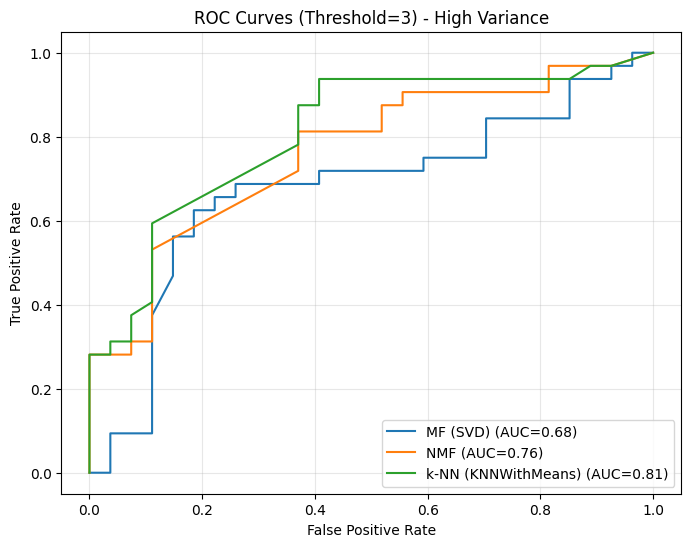

In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, KFold
from surprise import SVD, NMF, KNNWithMeans
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Function to plot ROC curves
def plot_roc_curve(predictions, threshold, model_name):
    r_ui = [1 if prediction.r_ui >= threshold else 0 for prediction in predictions]
    y_pred = [prediction.est for prediction in predictions]
    fpr, tpr, _ = roc_curve(r_ui, y_pred)
    auc_value = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC={auc_value:.2f})')

# Load datasets using Surprise reader
reader = Reader(rating_scale=(0, 5))

# Load the dataset from the user-item matrix
data = no_trimmed_data

# Define the trimming options
subset_datasets = {
    'Original': no_trimmed_data,
    'Popular': popular_trimmed_data,
    'Unpopular': unpopular_trimmed_data,
    'High Variance': high_variance_trimmed_data
}

#Models and parameters
models = {
    'MF (SVD)': SVD(n_factors=18, random_state=42),
    'NMF': NMF(n_factors=20, random_state=42),
    'k-NN (KNNWithMeans)': KNNWithMeans(k=16, sim_options={'name': 'pearson', 'user_based': True})
}

threshold = 3  # Threshold for ROC

kf = KFold(n_splits=10, random_state=42, shuffle=True)

# Compare models across subsets and plot ROC curves
for subset_name, subset_data in subset_datasets.items():
    print(f"Evaluating subset: {subset_name}")
    plt.figure(figsize=(8, 6))
    for model_name, model in models.items():
        for trainset, testset in kf.split(subset_data):
            model.fit(trainset)
            predictions = model.test(testset)
            plot_roc_curve(predictions, threshold, model_name)
            break  # One fold for ROC visualization

    plt.title(f"ROC Curves (Threshold={threshold}) - {subset_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


## QUESTION 13:
Data Understanding and Preprocessing:

* Use the provided helper code for loading and pre-processing Web10k data.

* Print out the number of unique queries in total and show distribution of relevance labels.

In [47]:
from sklearn.datasets import load_svmlight_file
import numpy as np

# Your existing function
def load_one_fold(data_path):
    X_train, y_train, qid_train = load_svmlight_file(str(data_path + 'train.txt'), query_id=True)
    X_test, y_test, qid_test = load_svmlight_file(str(data_path + 'test.txt'), query_id=True)
    X_val, y_val, qid_val = load_svmlight_file(str(data_path + 'vali.txt'), query_id=True)

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    y_val = y_val.astype(int)
    _, group_train = np.unique(qid_train, return_counts=True)
    _, group_test = np.unique(qid_test, return_counts=True)
    _, group_val = np.unique(qid_val, return_counts=True)
    return X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test, X_val, y_val, qid_val, group_val



# Assuming you have loaded your data using load_one_fold
data_path = PATH + 'Dataset/MSLR-WEB10K/'

from sklearn.datasets import load_svmlight_file
import numpy as np

# Your existing function
def load_one_fold(data_path):
    X_train, y_train, qid_train = load_svmlight_file(str(data_path + 'train.txt'), query_id=True)
    X_test, y_test, qid_test = load_svmlight_file(str(data_path + 'test.txt'), query_id=True)
    X_val, y_val, qid_val = load_svmlight_file(str(data_path + 'vali.txt'), query_id=True)

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    y_val = y_val.astype(int)
    _, group_train = np.unique(qid_train, return_counts=True)
    _, group_test = np.unique(qid_test, return_counts=True)
    _, group_val = np.unique(qid_val, return_counts=True)
    return X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test, X_val, y_val, qid_val, group_val



data_path = PATH + 'Dataset/MSLR-WEB10K/'



Number of unique queries in train set: 6000
Number of unique queries in val set: 2000
Number of unique queries in test set: 2000

Distribution of relevance labels in train set:
(array([0, 1, 2, 3, 4]), array([377957, 232569,  95082,  12658,   5146]))

Distribution of relevance labels in test set:
(array([0, 1, 2, 3, 4]), array([124784,  77896,  32459,   4450,   1932]))

Distribution of relevance labels in val set:
(array([0, 1, 2, 3, 4]), array([121522,  75815,  31910,   4209,   1803]))


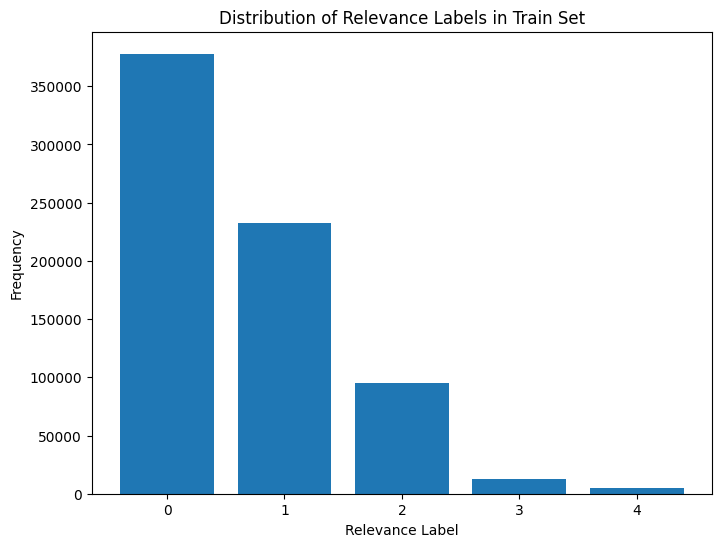

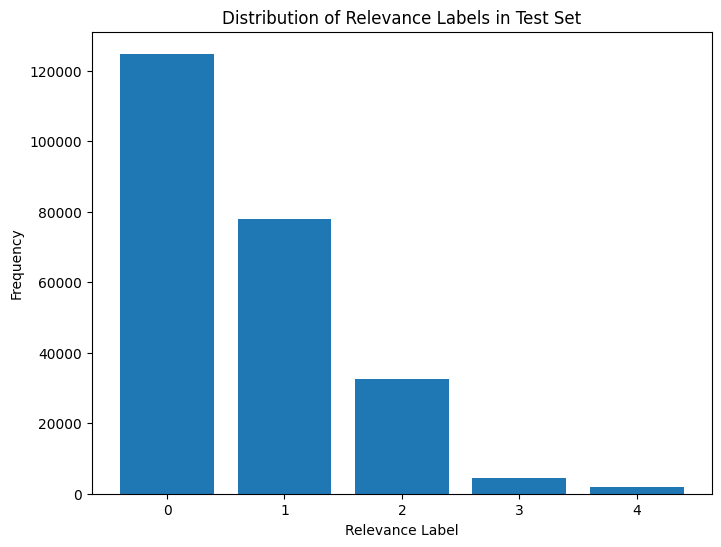

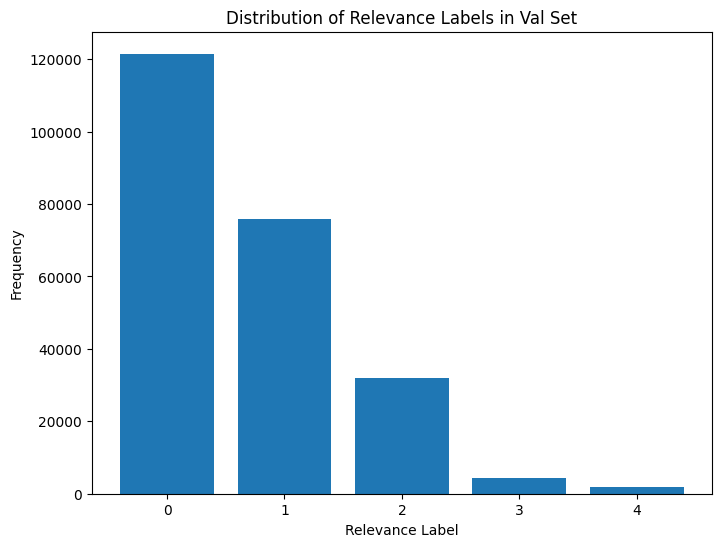

In [52]:
for i in range(1, 2):
  fold_path = data_path + "Fold" + str(i) + "/"
  X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test, X_val, y_val, qid_val, group_val = load_one_fold(fold_path)
# Print the number of unique queries
num_unique_queries_train = len(np.unique(qid_train))
num_unique_queries_val = len(np.unique(qid_val))
num_unique_queries_test = len(np.unique(qid_test))
print(f"Number of unique queries in train set: {num_unique_queries_train}")
print(f"Number of unique queries in val set: {num_unique_queries_val}")
print(f"Number of unique queries in test set: {num_unique_queries_test}")

# Show distribution of relevance labels
print("\nDistribution of relevance labels in train set:")
print(np.unique(y_train, return_counts=True))

print("\nDistribution of relevance labels in test set:")
print(np.unique(y_test, return_counts=True))

print("\nDistribution of relevance labels in val set:")
print(np.unique(y_val, return_counts=True))


# Function to plot the distribution of relevance labels with bars
def plot_relevance_distribution(labels, title):
    plt.figure(figsize=(8, 6))
    plt.bar(np.unique(labels), np.bincount(labels))
    plt.title(title)
    plt.xlabel('Relevance Label')
    plt.ylabel('Frequency')
    plt.show()


# Show distribution of relevance labels for train set
plot_relevance_distribution(y_train, 'Distribution of Relevance Labels in Train Set')

# Show distribution of relevance labels for test set
plot_relevance_distribution(y_test, 'Distribution of Relevance Labels in Test Set')

# Show distribution of relevance labels for val set
plot_relevance_distribution(y_val, 'Distribution of Relevance Labels in Val Set')


## QUESTION 14:
LightGBM Model Training:
For each of the five provided folds, train a LightGBM model using the ’lambdarank’ objective. After training, evaluate and report the model’s performance on the test set using nDCG@3, nDCG@5 and nDCG@10.

In [48]:
def ndcg_single_query(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

# calculate NDCG score given a trained model
def compute_ndcg_all(model, X_test, y_test, qids_test, k=10):
    unique_qids = np.unique(qids_test)
    ndcg_ = list()
    for i, qid in enumerate(unique_qids):
        y = y_test[qids_test == qid]

        if np.sum(y) == 0:
            continue

        p = model.predict(X_test[qids_test == qid])

        idcg = ndcg_single_query(y, y, k=k)
        ndcg_.append(ndcg_single_query(p, y, k=k) / idcg)
    return np.mean(ndcg_)

# get importance of features
def get_feature_importance(model, importance_type='gain'):
    return model.booster_.feature_importance(importance_type=importance_type)

In [49]:
import lightgbm as lgb
from lightgbm import log_evaluation, early_stopping


# LightGBM parameters (you may need to adjust these based on your dataset)
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_at': [3, 5, 10],
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

ndcg_3_scores = []
ndcg_5_scores = []
ndcg_10_scores = []

# Train and evaluate LightGBM model for each fold
for fold in range(1, 6):
    print(f"Fold{fold}")
    # Assuming you have data for the current fold (X_train_fold, y_train_fold, qid_train_fold, X_test_fold, y_test_fold, qid_test_fold)
    fold_path = data_path + "Fold" + str(fold) + "/"
    X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test, X_val, y_val, qid_val, group_val = load_one_fold(fold_path)
    train_data = lgb.Dataset(X_train, label=y_train, group=group_train)
    val_data = lgb.Dataset(X_val, label=y_val, group=group_val, reference=train_data)
    test_data = lgb.Dataset(X_test, label=y_test, group=group_test, reference=train_data)
    callbacks = [early_stopping(stopping_rounds=50)]

    # Train the LightGBM model
    model = lgb.train(params, train_data, valid_sets=[val_data], num_boost_round=200, callbacks=callbacks)

    # Predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate nDCG at 3, 5, and 10
    # Assuming you have a trained LightGBM model named 'trained_model'

    # Calculate NDCG scores
    ndcg_at_3 = compute_ndcg_all(model, X_test, y_test, qid_test, k=3)
    ndcg_at_5 = compute_ndcg_all(model, X_test, y_test, qid_test, k=5)
    ndcg_at_10 = compute_ndcg_all(model, X_test, y_test, qid_test, k=10)

    ndcg_3_scores.append(ndcg_at_3)
    ndcg_5_scores.append(ndcg_at_5)
    ndcg_10_scores.append(ndcg_at_10)

    print("\nTest set metrics:")
    print(f"NDCG@3: {ndcg_at_3:.4f}")
    print(f"NDCG@5: {ndcg_at_5:.4f}")
    print(f"NDCG@10: {ndcg_at_10:.4f}\n")

Fold1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25637
[LightGBM] [Info] Number of data points in the train set: 723412, number of used features: 136
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's ndcg@3: 0.484881	valid_0's ndcg@5: 0.490317	valid_0's ndcg@10: 0.507208

Test set metrics:
NDCG@3: 0.4568
NDCG@5: 0.4627
NDCG@10: 0.4830

Fold2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25623
[LightGBM] [Info] Number of data points in the train set: 716683, number of used features: 136
Training unti

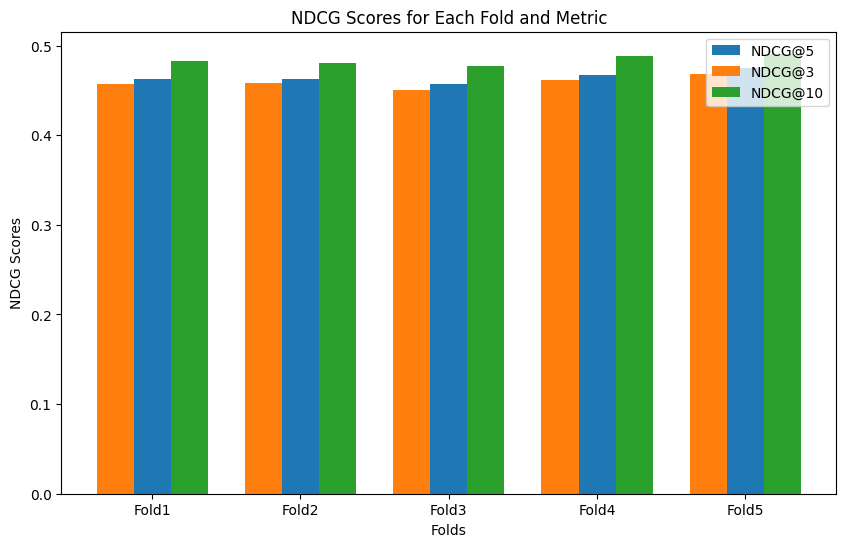

In [50]:
# Plotting the bar chart
labels = [i for i in range(1, 6)]
bar_width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(labels, ndcg_5_scores, width=bar_width, label='NDCG@5', tick_label=[f"Fold{i}" for i in labels])
bar2 = ax.bar([label - bar_width for label in labels], ndcg_3_scores, width=bar_width, label='NDCG@3')
bar3 = ax.bar([label + bar_width for label in labels], ndcg_10_scores, width=bar_width, label='NDCG@10')


ax.set_xlabel('Folds')
ax.set_ylabel('NDCG Scores')
ax.set_title('NDCG Scores for Each Fold and Metric')
ax.legend()


plt.show()

## QUESTION 15:
Result Analysis and Interpretation:

For each of the five provided folds, list top 5 most important features of the model based on the importance score. Please use model.booster .feature importance(importance type=’gain’) as demonstrated here for retrieving importance score per feature. You can also find helper code in the
provided notebook.

In [53]:
import lightgbm as lgb

# LightGBM parameters (you may need to adjust these based on your dataset)
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_at': [3, 5, 10],
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Loop through each fold
for fold in range(1, 6):
    # Assuming you have data for the current fold (X_train_fold, y_train_fold, qid_train_fold, X_test_fold, y_test_fold, qid_test_fold)
    fold_path = data_path + "Fold" + str(fold) + "/"
    X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test, X_val, y_val, qid_val, group_val = load_one_fold(fold_path)
    train_data = lgb.Dataset(X_train, label=y_train, group=group_train)
    val_data = lgb.Dataset(X_val, label=y_val, group=group_val, reference=train_data)
    test_data = lgb.Dataset(X_test, label=y_test, group=group_test, reference=train_data)
    callbacks = [early_stopping(stopping_rounds=50)]

    # Train the LightGBM model
    model = lgb.train(params, train_data, valid_sets=[val_data], num_boost_round=100, callbacks=callbacks)

    # Retrieve feature importance scores
    importance_scores = model.feature_importance(importance_type='gain')

    # Get the indices of the top 5 features
    top5_feature_indices = np.argsort(importance_scores)[::-1][:5]

    # Print the results for the current fold
    print(f"\nTop 5 most important features for Fold {fold}:")
    for i, feature_name in enumerate(top5_feature_indices):
        print(f"{i + 1}. Feature importance order: {feature_name} (Importance Score: {importance_scores[top5_feature_indices[i]]:.4f})\n")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25637
[LightGBM] [Info] Number of data points in the train set: 723412, number of used features: 136
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's ndcg@3: 0.479184	valid_0's ndcg@5: 0.482666	valid_0's ndcg@10: 0.500495

Top 5 most important features for Fold 1:
1. Feature importance order: 133 (Importance Score: 51292.1303)

2. Feature importance order: 7 (Importance Score: 9343.8271)

3. Feature importance order: 54 (Importance Score: 7850.2545)

4. Feature importance order: 107 (Importance Score: 7443.2846)

5. Feature importance order: 128 (Importance Score: 6251.0688)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 

## QUESTION 16:
Experiments with Subset of Features:

For each of the five provided folds:

* Remove the top 20 most important features according to the computed importance score in the question 15. Then train a new LightGBM model on the resulted 116 dimensional query-url data. Evaluate the performance of this new model on the test set using nDCG. Does the outcome align with your expectations? If not, please share your hypothesis regarding the potential reasons for this discrepancy.

* Remove the 60 least important features according to the computed importance score in the question 15. Then train a new LightGBM model on the resulted 76 dimensional query-url data. Evaluate the performance of this new model on the test set using nDCG. Does the outcome align with your expectations? If not, please share your hypothesis regarding the potential reasons for this discrepancy.

**Answer**
As expected, removing the top 20 most important features caused a decline in nDCG scores, indicating that key information essential for precise ranking was lost. Surprisingly, eliminating the 60 least important features yielded results similar to the original model, which contradicted my initial expectation of performance improvement. This outcome implies that these less significant features might be redundant. Alternatively, it’s possible that these features do not contribute additional noise, and therefore, their presence or absence has minimal effect on the model’s overall accuracy.

In [ ]:
import lightgbm as lgb

# LightGBM parameters (you may need to adjust these based on your dataset)
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_at': [3, 5, 10],
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Loop through each fold
for fold in range(1, 6):
    # Assuming you have data for the current fold (X_train_fold, y_train_fold, qid_train_fold, X_test_fold, y_test_fold, qid_test_fold)
    fold_path = data_path + "Fold" + str(fold) + "/"
    X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test, X_val, y_val, qid_val, group_val = load_one_fold(fold_path)
    train_data = lgb.Dataset(X_train, label=y_train, group=group_train)
    val_data = lgb.Dataset(X_val, label=y_val, group=group_val, reference=train_data)
    test_data = lgb.Dataset(X_test, label=y_test, group=group_test, reference=train_data)
    callbacks = [early_stopping(stopping_rounds=50)]

    # Train the LightGBM model
    model = lgb.train(params, train_data, valid_sets=[val_data], num_boost_round=200, callbacks=callbacks)

    # Retrieve feature importance scores
    importance_scores = model.feature_importance(importance_type='gain')


    # Get the indices of the top 20 and bottom 60 features
    top20_feature_indices = np.argsort(importance_scores)[::-1][:20]
    bottom60_feature_indices = np.argsort(importance_scores)[:60]

    # Remove the top 20 features
    X_train_subset_1 = np.delete(X_train.toarray(), top20_feature_indices, axis=1)
    X_test_subset_1 = np.delete(X_test.toarray(), top20_feature_indices, axis=1)
    X_val_subset_1 = np.delete(X_val.toarray(), top20_feature_indices, axis=1)

    # Train a new LightGBM model on the resulted 116-dimensional query-url data
    model_subset_1 = lgb.train(params, lgb.Dataset(X_train_subset_1, label=y_train, group=group_train),
                               valid_sets=[lgb.Dataset(X_val_subset_1, label=y_val, group=group_val)],
                               num_boost_round=200, callbacks=callbacks)





    # Remove the bottom 60 features
    X_train_subset_2 = np.delete(X_train.toarray(), bottom60_feature_indices, axis=1)
    X_test_subset_2 = np.delete(X_test.toarray(), bottom60_feature_indices, axis=1)
    X_val_subset_2 = np.delete(X_val.toarray(), bottom60_feature_indices, axis=1)


    # Train a new LightGBM model on the resulted 76-dimensional query-url data
    model_subset_2 = lgb.train(params, lgb.Dataset(X_train_subset_2, label=y_train, group=group_train),
                               valid_sets=[lgb.Dataset(X_val_subset_2, label=y_val, group=group_val)],
                               num_boost_round=200, callbacks=callbacks)


    ndcg_origin = compute_ndcg_all(model, X_test, y_test, qid_test, k=10)
    print(f"\nFold {fold} - nDCG original: {ndcg_origin:.4f}\n")

    # Evaluate the performance on the test set using nDCG
    ndcg_subset_1 = compute_ndcg_all(model_subset_1, X_test_subset_1, y_test, qid_test, k=10)
    print(f"\nFold {fold} - nDCG after removing top 20 features: {ndcg_subset_1:.4f}\n")

    # Evaluate the performance on the test set using nDCG
    ndcg_subset_2 = compute_ndcg_all(model_subset_2, X_test_subset_2, y_test, qid_test, k=10)
    print(f"\nFold {fold} - nDCG after removing least 60 features: {ndcg_subset_2:.4f}\n")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.166468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25637
[LightGBM] [Info] Number of data points in the train set: 723412, number of used features: 136
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's ndcg@3: 0.484881	valid_0's ndcg@5: 0.490317	valid_0's ndcg@10: 0.507208
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21482
[LightGBM] [Info] Number of data points in the train set: 723412, number of used features: 116
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/

In [ ]:
!jupyter nbconvert "ECE219_project3.ipynb" --to PDF